# Solving Zermelo's Problem Via Direct Methods

In [1]:
import matplotlib.pyplot as plt
import numpy as np
from scipy.interpolate import interp1d
from scipy.optimize import minimize, Bounds

Zermelo's navigation problem is a classic optimal control problem proposed in 1931 by Ernst Zermelo. In it, we have a ship that must cross a flowing river from a point on one bank to a point on the opposite bank. The ship travels at a fixed forward velocity. We can control its heading, which is bounded.

<center><img src="zermelo.png" width="600"/></center>

Our version of this optimal control problem is formulated as
$$
\begin{aligned}
\operatorname*{minimize}_{u(t)}\enspace
&\int_0^{t_f} u(t)^2 \,dt
\\
\operatorname{subject~to}\enspace
&\dot{x}(t) = v\cos(u(t)) + \text{flow}(y(t)),\quad \forall t \in [0,t_f] \\
&\dot{y}(t) = v\sin(u(t),\quad \forall t \in [0,t_f] \\
&(x(0), y(0)) = (0,0) \\
&(x(t_f), y(t_f)) = (M,\ell) \\
&|u(t)| \leq u_{\text{max}},\quad \forall t \in [0,t_f]
\end{aligned}
$$
where $x(t)$ is the position of the ship along the river bank, $y(t)$ is the position of the ship across the water, $v > 0$ is the fixed forward velocity of the ship, $(M, \ell)$ is the position we wish to reach, and $\text{flow}(y(t))$ represents the effect of the flowing water on our ship. Overall, we want to minimize the control effort used to reach our destination.

For this problem we will consider $M = 10$ and speed $v=1$.

In [2]:
M = 10
v = 1

For this problem we will define the flow using the model:
$$
\text{flow}(y(t)) = \frac{0.35}{\frac{l^2}{4}}y(l-y)
$$
which has zero flow when $y=0$ and $y=l$ and reaches peak flow of $0.35$ at $y = l/2$.

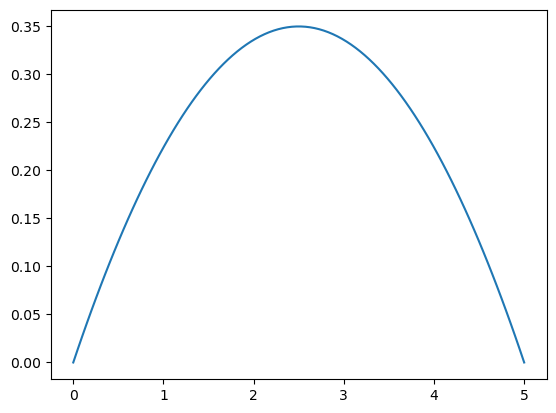

In [3]:
l = 5
flow = lambda y: 0.35 / (l**2 / 4) * y * (l - y)
y = np.linspace(0, l, 100)
plt.plot(y, flow(y))
plt.show()

## Direct Collocation Method

We can solve Zermelo's Problem using direct collocation, where the decision variables are the state trajectory variables $(x,y)$ and the control $u$ at the discrete time points.

In [4]:
def zermelo_direct_collocation(t_f, N, u_max=1.0, z0=None, verbose=True):
    h = t_f / N # discretization time step

    # Decision variables: (x_i, y_i, u_i), i = 0, ..., N
    # z = np.concatenate([x, y, u])
    get_x = lambda z: z[:N + 1]
    get_y = lambda z: z[N + 1:-N]
    get_u = lambda z: z[-N:]
    get_z = lambda x, y, u: np.concatenate([x, y, u])

    # Cost function
    cost = lambda z: np.sum(h * np.square(get_u(z)))

    # Define dynamics and initial/final condition constraints
    def equality_constraints(z):
        x, y, u = get_x(z), get_y(z), get_u(z)
        constraints = []
        for i in range(N):
            # Dynamics constraints
            constraints.append(x[i+1] - x[i] - h * (v * np.cos(u[i]) + flow(y[i])))
            constraints.append(y[i+1] - y[i] - h * v * np.sin(u[i]))
        constraints.extend([x[0], y[0], x[N] - M, y[N] - l]) # boundary conditions
        return np.array(constraints)

    # Decision variable bounds
    eps = 1e-3  # `minimize` can be a bit finicky about constraints, so slightly loosen state/control inequality constraints
    x_lower = np.zeros(N + 1)
    x_upper = M * np.ones(N + 1)
    y_lower = np.zeros(N + 1)
    y_upper = l * np.ones(N + 1)
    u_lower = -u_max * np.ones(N) # control constraint
    u_upper = u_max * np.ones(N)  # control constraint
    bounds = Bounds(get_z(x_lower, y_lower, u_lower) - eps, get_z(x_upper, y_upper, u_upper) + eps)

    # Specify initial guess
    if z0 is None:
        x0 = np.ones(N + 1)
        y0 = np.ones(N + 1)
        u0 = 0.5 * u_max * np.ones(N)
        z0 = get_z(x0, y0, u0)

    # Optimize
    result = minimize(cost,
                      z0,
                      bounds=bounds,
                      constraints={
                          'type': 'eq',
                          'fun': equality_constraints
                      },
                      options={'maxiter': 1000})
    if verbose:
        print(result)

    return get_x(result.x), get_y(result.x), get_u(result.x)

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 3.6775643328509218
       x: [-9.659e-20  5.000e-01 ...  3.681e-01  1.583e-01]
     nit: 50
     jac: [ 0.000e+00  0.000e+00 ...  3.684e-01  1.584e-01]
    nfev: 3187
    njev: 50


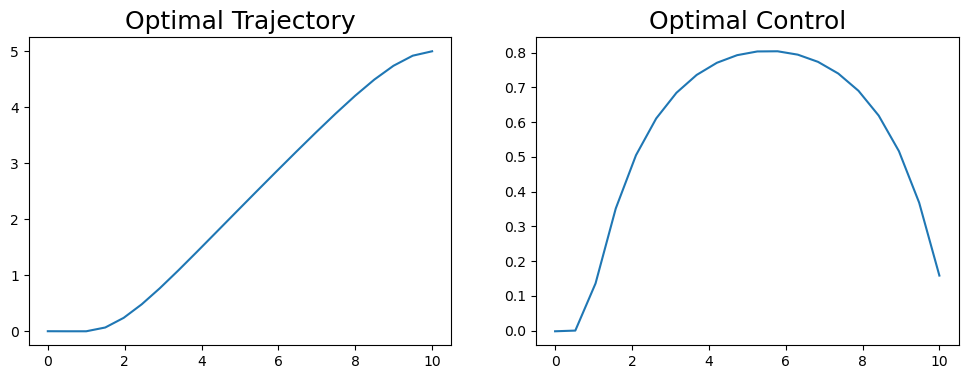

In [9]:
t_f = 10 # final time
N = 20 # number of discretization steps
x_opt, y_opt, u_opt = zermelo_direct_collocation(t_f, N, u_max=1.)
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(x_opt, y_opt)
plt.title("Optimal Trajectory", fontsize=18)
plt.subplot(1, 2, 2)
plt.title("Optimal Control", fontsize=18)
plt.plot(np.linspace(0, t_f, N), u_opt)

In the code below we run the same problem but with a different $u_{\text{max}}$ value, but we use the solution from the previous problem to warmstart the optimization. Notice that the number of iterations (nit) decreases.

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 3.6866016148316114
       x: [-5.765e-20  5.000e-01 ...  3.820e-01  1.145e-01]
     nit: 6
     jac: [ 0.000e+00  0.000e+00 ...  3.815e-01  1.143e-01]
    nfev: 380
    njev: 6


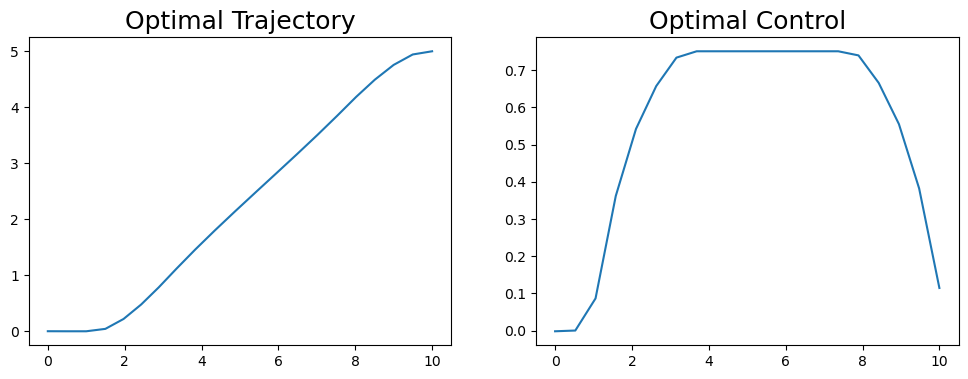

In [6]:
x_opt, y_opt, u_opt = zermelo_direct_collocation(t_f, N, u_max=0.75, z0=np.concatenate([x_opt, y_opt, u_opt]))
plt.figure(figsize=(12, 4))
plt.subplot(1, 2, 1)
plt.plot(x_opt, y_opt)
plt.title("Optimal Trajectory", fontsize=18)
plt.subplot(1, 2, 2)
plt.title("Optimal Control", fontsize=18)
plt.plot(np.linspace(0, t_f, N), u_opt)

## Direct Shooting Method

We will now solve the same problem using a direct shooting method where the optimization variables only include the control values.

In [7]:
def zermelo_direct_shooting(t_f, N, u_max=1.0, u0=None, verbose=True):
    h = t_f / N # discretization time step

    # Decision variables: (u_i), i = 0, ..., N - 1
    # Cost function
    cost = lambda u: np.sum(h * np.square(u))

    # Define dynamics
    dynamics = lambda x, y, u: (
        x + h * (v * np.cos(u) + flow(y)),
        y + h * np.sin(u)
    )

    # Define problem constraints as inequality constraints
    def inequality_constraints(u):
        x, y = 0, 0 # initial condition (x(0), y(0)) = (0, 0)
        constraints = []
        for ui in u:
            x, y = dynamics(x, y, ui)
            constraints.extend([x, y]) # constrain (x,y) >= (0,0)
            constraints.extend([M - x, l - y]) # constrain (x,y) <= (M,l)
        # At the end of the trajectory, apply terminal constraints (x,y) >= (M,l)
        # which along with constraint (x,y) <= (M,l) produces the equality constraint
        constraints.extend([x - M, y - l])
        return constraints

    # Control constraint |u| <= u_max
    bounds = Bounds(-u_max * np.ones(N), u_max * np.ones(N))

    # Specify initial guess
    if u0 is None:
        u0 = 0.5 * u_max * np.ones(N)

    # Optimize
    result = minimize(cost,
                      u0,
                      bounds=bounds,
                      constraints={
                          'type': 'ineq',
                          'fun': inequality_constraints
                      },
                      options={'maxiter': 1000})
    if verbose:
        print(result)

    return result.x

 message: Optimization terminated successfully
 success: True
  status: 0
     fun: 3.677827084088736
       x: [-7.210e-15 -3.009e-15 ...  3.641e-01  1.527e-01]
     nit: 9
     jac: [ 2.980e-08  2.980e-08 ...  3.641e-01  1.527e-01]
    nfev: 189
    njev: 9


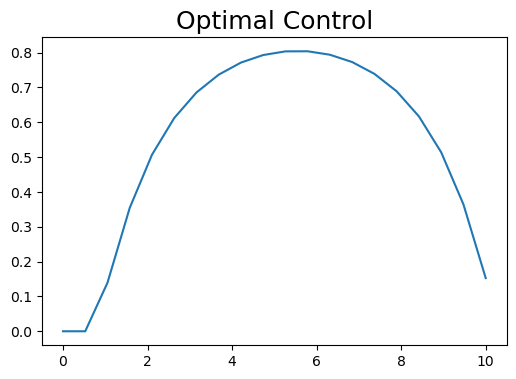

In [8]:
t_f = 10 # final time
N = 20 # number of discretization steps
u_opt = zermelo_direct_shooting(t_f, N, u_max=1.)
plt.figure(figsize=(6, 4))
plt.title("Optimal Control", fontsize=18)
plt.plot(np.linspace(0, t_f, N), u_opt)